In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from metpy.interpolate import cross_section 
from matplotlib import colormaps as cm
from matplotlib.ticker import NullFormatter


In [19]:
def compute_dy(lats,lons):
    
    rE = 6.3781E6 #radius of the Earth
    
    dy = np.array([])
    
    #Iterate through each lat/lon and compute the great circle distance between the two points
    for i in range(len(lats)-1):
        
        #All angles must be in radians
        lat1 = np.radians(lats[i])
        lat2 = np.radians(lats[i+1])
        lon1 = np.radians(lons[i])
        lon2 = np.radians(lons[i+1])
    
        #Compute the great circle distance
        deltalon = lon2-lon1
        term1 = np.sin(lat1)*np.sin(lat2)
        term2 = np.cos(lat1)*np.cos(lat2)*np.cos(deltalon)
        centralangle = np.arccos(term1 + term2)
        dist = rE*centralangle
        
        #Save this distance (units: meters) into our output array
        dy = np.append(dy,dist)
    
    return dy

In [20]:
def load_datasets(year, month, start_day, start_hour=0, end_day=None, end_hour=23):
    """
    Load datasets for specified start day, month, and year.
    
    Parameters:
        year (int): The year of the data.
        month (int): The month of the data.
        start_day (int): The start day of the data.
        start_hour (int, optional): The hour of the start day. Defaults to 0.
        end_day (int, optional): The end day of the data. Defaults to start_day.
        end_hour (int, optional): The hour of the end day. Defaults to 23.
        
    Returns:
        tuple: Xarray Datasets for pressure level and surface datasets.
    """
    
    # Set end_day to start_day if not provided
    if end_day is None:
        end_day = start_day
    
    # Get the last day of the month
    last_day_of_month = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(1)
    last_day_str = f"{last_day_of_month.day:02d}"  # format last day as two digits

    # Format date and time strings
    year_month = f'{year}{month:02d}'
    start_time = f'{year}{month:02d}{start_day:02d}{start_hour:02d}'  # yyyymmddhh (start)
    end_time = f'{year}{month:02d}{end_day:02d}{end_hour:02d}'  # yyyymmddhh (end)

    # Define URLs for pressure level datasets with specific time ranges
    urls = {
        'temperature_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_130_t.ll025sc.{start_time}_{end_time}.nc',
        'geopotential_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_129_z.ll025sc.{start_time}_{end_time}.nc',
        'humidity_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_133_q.ll025sc.{start_time}_{end_time}.nc',
        'v_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_132_v.ll025uv.{start_time}_{end_time}.nc',
        'u_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_131_u.ll025uv.{start_time}_{end_time}.nc',
        'w_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_135_w.ll025sc.{start_time}_{end_time}.nc',
        'pv_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_060_pv.ll025sc.{start_time}_{end_time}.nc',
        
        # Define URLs for surface datasets to cover the full month using last_day_of_month
        'mslp_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_151_msl.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'u_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_131_u10n.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'v_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_132_v10n.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'temperature_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_167_2t.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc',
        'dew_point_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_168_2d.ll025sc.{year_month}0100_{year_month}{last_day_str}23.nc'
    }

    # Initialize empty dictionaries for datasets
    datasets = {}

    # Try to load datasets from the URLs
    for var, url in urls.items():
        try:
            tds_catalog = TDSCatalog(url)
            ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
            ds = xr.open_dataset(ds_url).metpy.parse_cf()
            datasets[var] = ds
            print(f"Successfully loaded {var}")

        except Exception as e:
            print(f"Error loading {var}: {e}")

    # Merge pressure level datasets if available
    ds_pl, ds_sfc = None, None

    try:
        ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], 
                        datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['w_wind_pl'], datasets['pv_pl']])
        print("Successfully merged pressure level datasets")
    except KeyError as e:
        print(f"Error merging pressure level datasets: {e}")

    # Merge surface datasets if available
    try:
        ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc'],
                        datasets['temperature_sfc'], datasets['dew_point_sfc']])
        print("Successfully merged surface datasets")
    except KeyError as e:
        print(f"Error merging surface datasets: {e}")

    # Synchronize time dimensions
    try:
        if ds_pl is not None and ds_sfc is not None:
            first_time_pl, last_time_pl = ds_pl['time'].min().values, ds_pl['time'].max().values
            ds_sfc = ds_sfc.sel(time=slice(first_time_pl, last_time_pl))
    except KeyError as e:
        print(f"Error accessing 'time' in the datasets: {e}")
    except Exception as e:
        print(f"An error occurred during slicing: {e}")
        
    return ds_pl, ds_sfc



variable_name = 'fgen_cross_diagonal'
year = 2019
month = 2
first_day = 13
last_day = first_day
directions = {'North': 55, 
            'East': 250, 
            'South': 20, 
            'West': 200} # units: degrees North, degrees East
start_point = (30, 360 - 134) # units: degrees North, degrees East
end_point = (36, 360 - 127) # units: degrees North, degrees East
g = 9.81 # units: m/s^2

ds_pl, ds_sfc = load_datasets(year=year, month=month, start_day=first_day, end_day=last_day, start_hour=0, end_hour=23)

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded geopotential_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded humidity_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_135_w.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded w_wind_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019021300_2019021323.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019021300_2019021323.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded pv_pl


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded mslp_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded u_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded v_wind_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_167_2t.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_167_2t.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded temperature_sfc


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_168_2d.ll025sc.2019020100_2019022823.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_168_2d.ll025sc.2019020100_2019022823.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Successfully loaded dew_point_sfc
Successfully merged pressure level datasets
Successfully merged surface datasets


In [21]:
ds_sliced = ds_pl.isel(time=0)
ds_sfc_sliced = ds_sfc.isel(time=0)
# Slice the dataset to get the data for the region of interest
ds_pl_sliced = ds_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

In [22]:
u_3d = ds_pl_sliced['U'] * units.meter / units.second # units: m/s
v_3d = ds_pl_sliced['V'] * units.meter / units.second # units: m/s
gph_3d = ds_pl_sliced['Z'] * (units.meter**2) / (units.second**2) # units: m2/s2

u_250 = ds_pl_sliced['U'].sel(level=250) * units.meter / units.second # units: m/s
v_250 = ds_pl_sliced['V'].sel(level=250) * units.meter / units.second # units: m/s

temp_3d = ds_pl_sliced['T'] * units.kelvin # units: K
w_3d = ds_pl_sliced['W'] * units.pascal / units.second # units: Pa/s

wind_speed_250 = np.sqrt(u_250**2 + v_250**2)

In [23]:
lonW = 250               # westernmost longitude in domain, must be between 0º and 360º
lonE = 310               # easternmost longitude in domain, must be between 0º and 360º

In [24]:
# Set constants we need for later calculations
Rd  = 287.06 * (units.joule) / (units.kilogram * units.kelvin) # gas constant for dry air
cp  = 1005 * (units.joule) / (units.kilogram * units.kelvin)   # specific heat at constant pressure for dry air
cv = 718 * (units.joule) / (units.kilogram * units.kelvin)    # specific heat at constant volume for dry air
rE  = 6.3781E6 * units.meter                                   # radius of the Earth

In [25]:
temp_3d

<xarray.DataArray 'T' (level: 37, latitude: 141, longitude: 201)>
<Quantity([[[230.68625 230.36008 230.05344 ... 253.6843  253.74094 253.79172]
  [230.9382  230.61398 230.3132  ... 253.97726 254.05539 254.12766]
  [231.19211 230.87375 230.58469 ... 254.3386  254.43625 254.53   ]
  ...
  [262.56516 262.13156 261.8347  ... 271.5378  271.64133 271.67258]
  [262.57297 262.1921  261.9753  ... 271.4128  271.5222  271.58273]
  [262.64328 262.30734 262.1472  ... 271.18625 271.29172 271.36594]]

 [[211.93756 212.1524  212.37311 ... 233.70709 233.89264 234.06647]
  [212.34186 212.55084 212.75983 ... 234.47076 234.65045 234.82428]
  [212.77545 212.97858 213.17389 ... 235.2442  235.43951 235.62897]
  ...
  [254.62897 254.65826 254.6485  ... 257.4942  257.37115 257.24225]
  [254.34967 254.336   254.28717 ... 257.6524  257.63873 257.59576]
  [254.23053 254.20123 254.12897 ... 257.78522 257.8692  257.90826]]

 [[210.21219 210.1614  210.1282  ... 225.32742 225.44266 225.55789]
  [210.46414 210.41727 210.38992 ... 225.73563 225.87234 226.00906]
  [210.72781 210.68484 210.66727 ... 226.06766 226.21805 226.36844]
  ...
...
  ...
  [289.2166  289.25763 289.27716 ... 289.9002  289.9588  289.9881 ]
  [289.31036 289.34943 289.40997 ... 289.9627  290.07794 290.04865]
  [289.3631  289.37482 289.49396 ... 290.03497 290.1717  290.18536]]

 [[272.96375 273.03796 273.11804 ... 256.00476 255.8368  255.72548]
  [273.07117 273.15906 273.22742 ... 255.50673 255.24892 255.11024]
  [273.3192  273.4071  273.46765 ... 254.40712 254.22353 254.20985]
  ...
  [291.3817  291.42468 291.4325  ... 292.0575  292.11414 292.1454 ]
  [291.47156 291.51257 291.57312 ... 292.13953 292.2079  292.2235 ]
  [291.5282  291.55164 291.6571  ... 292.2235  292.3075  292.36218]]

 [[274.91547 275.00922 275.09515 ... 257.2436  257.06195 256.94672]
  [274.92523 275.02484 275.1264  ... 256.74945 256.4936  256.33148]
  [275.13422 275.25336 275.3471  ... 255.64398 255.47015 255.44672]
  ...
  [293.54437 293.58344 293.58148 ... 294.20258 294.2768  294.28656]
  [293.62054 293.6811  293.7182  ... 294.2514  294.3471  294.3764 ]
  [293.68304 293.71625 293.82172 ... 294.3803  294.45258 294.5307 ]]], 'kelvin')>
Coordinates:
    time       datetime64[ns] 2019-02-13
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 20.5 20.25 20.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float64 200.0 200.2 200.5 200.8 ... 249.5 249.8 250.0
    metpy_crs  object Projection: latitude_longitude

In [26]:
# Obtain values of latitude, longitude, pressure
# Convert pressure from hectopascals to pascals for ease with later calculations
press = temp_3d.level * 100 * units.pascal
lats  = temp_3d.latitude * units.degrees
lons  = temp_3d.longitude * units.degrees

# Create 3D arrays of pressure, lat, and lon
lats_3d, press_3d, lons_3d = np.meshgrid(lats, press, lons)

# Get the 3D difference in pressure between adjacent pressure levels
# This pressure difference should NOT change across the entire 3D grid
dp = np.diff(press)
___, dp_3d, __ = np.meshgrid(lats, dp, lons)
dp_3d = dp_3d * units.pascal

# Get the difference in latitude and longitude between adjacent values in radians
# These differences also should NOT change across the entire 3D grid
dlon = np.radians(np.abs(np.diff(lons)[0]))
dlat = np.radians(np.abs(np.diff(lats)[0]))

# Create arrays of the x and y distance between adjacent values in the latitude and longitude arrays
dx_3d, dy_3d = mpcalc.lat_lon_grid_deltas(lons_3d, lats_3d)

# Use the temperature and pressure to calculate potential temperature at the current time
press_ref = 100000 * units.pascal
tpot_3d = temp_3d*((press_ref/press_3d)**(Rd/cp))

# Calculate the gradient in potential temperature to retrieve the spatial derivatives
# of potential temperature
grad_tpot = mpcalc.gradient(tpot_3d, deltas=(dp_3d,dy_3d,dx_3d))
dtpot_dx  = grad_tpot[2]
dtpot_dy  = grad_tpot[1]
dtpot_dp  = grad_tpot[0] 

# Load in the files at the previous and following hour, and obtain potential temperature at those times
file_sub1hr  = ds_pl.isel(time=0)
file_plus1hr = ds_pl.isel(time=1)
temp_3d_sub1hr  = file_sub1hr['T'].sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
temp_3d_plus1hr = file_plus1hr['T'].sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
temp_3d_sub1hr  = temp_3d_sub1hr * units.kelvin
temp_3d_plus1hr = temp_3d_plus1hr * units.kelvin
tpot_3d_sub1hr  = temp_3d_sub1hr*((press_ref/press_3d)**(Rd/cp))
tpot_3d_plus1hr = temp_3d_plus1hr*((press_ref/press_3d)**(Rd/cp))

# Use a centered-in-space finite difference to calculate the time derivative of potential temperature
time_diff = 1 * 3600 * units.second  # difference in time relative to central time
dtpot_dt = ((tpot_3d_plus1hr - tpot_3d_sub1hr)/(2*time_diff))

# To save memory, delete the variables we needed solely for this time derivative calculation
del file_sub1hr, file_plus1hr, temp_3d_sub1hr, temp_3d_plus1hr, tpot_3d_sub1hr, tpot_3d_plus1hr

# Finally, calculate the diabatic heating rate
sum_of_terms = dtpot_dt + (u_3d * dtpot_dx) + (v_3d * dtpot_dy) + (w_3d * dtpot_dp)
diab_heat_rate = (temp_3d/tpot_3d) * sum_of_terms # units: Kelvin / second

In [27]:
# Take the cross section

# Use the geopotential height to calculate U and V components of geostrophic wind
ugeo_3d, vgeo_3d = mpcalc.geostrophic_wind(gph_3d)

# Combine all the variables we want on the cross section into one Dataset 
# Assign a coordinate system to the Dataset (Metpy needs this to compute the cross section)
xsect_vars = xr.Dataset(data_vars = {'ugeo' : ugeo_3d,
                                     'vgeo' : vgeo_3d,
                                     'tpot' : tpot_3d,
                                     'diab_heat_rate' : diab_heat_rate})
xsect_vars = xsect_vars.metpy.assign_crs(grid_mapping_name='latitude_longitude', earth_radius=rE.m)

# Take the cross section of all the variables
xsect = cross_section(xsect_vars, [start_point[0], start_point[1]], [end_point[0], end_point[1]], steps=100, interp_type='linear')

In [28]:
# Compute the Coriolis parameter using the latitude at each point along the cross section,
# and turn it into a 2D array for later calculations
cor = mpcalc.coriolis_parameter(xsect.latitude)
cor_2d, __ = np.meshgrid(cor, xsect.level)
cor_2d = cor_2d * (1 / units.second)

# Separate geostrophic wind on the cross-section into along-cross-section (V') and across-cross-section (U')
# components
vprime, uprime = mpcalc.cross_section_components(xsect['ugeo'],xsect['vgeo'])

# Metpy uses different cross-section conventions than we do for the Sawyer Eliassen equation. To match our
# conventions, reverse the direction of U'
uprime = uprime * (-1)

# Compute the difference in distance between adjacent points in the cross section
# We'll name this distance "dy" because in our new coordinate system, y runs along
# the length of the cross section
dy = compute_dy(xsect.latitude, xsect.longitude)

# Calculate a cumulative sum at each element in the array so that each point in the cross section is assigned
# a total distance in the y direction starting from a y-value of 0. We need to add an additional value of
# zero to the array since dy has a length one less than the number of cross section points. 
ydist = np.append([0],np.cumsum(dy)) * units.meter

# Make 2D arrays of pressure and y distance
# Convert pressure to pascals for ease with later calculations
press = xsect.level.values * 100 * units.pascal
ydist_2d, press_2d = np.meshgrid(ydist, press)

# Compute geostrophic absolute momentum
Mg = uprime - (cor_2d*ydist_2d)

# Compute the thermodynamic constant gamma along the cross section
gamma = Rd/(cor_2d*press_ref)*((press_ref/press_2d)**(cv/cp))

# Compute derivatives that appear in the coefficients for the Saywer Eliassen equation
dtpot_dy    = mpcalc.first_derivative(xsect['tpot'], axis=1, x=ydist)
dtpot_dp    = mpcalc.first_derivative(xsect['tpot'], axis=0, x=press)
duprime_dy  = mpcalc.first_derivative(uprime, axis=1, x=ydist)
duprime_dp  = mpcalc.first_derivative(uprime, axis=0, x=press)
dvprime_dy  = mpcalc.first_derivative(vprime, axis=1, x=ydist)
dvprime_dp  = mpcalc.first_derivative(vprime, axis=0, x=press)
dMg_dy      = mpcalc.first_derivative(Mg, axis=1, x=ydist)
dMg_dp      = mpcalc.first_derivative(Mg, axis=0, x=press)
dJ_dy       = mpcalc.first_derivative(xsect['diab_heat_rate'], axis=1, x=ydist)

# Compute x-derivative of potential temperature using thermal wind balance (since we have no other information
# on potential temperature changes in the x-direction with this cross-section) 
dtheta_dx = -1 * dvprime_dp/gamma

# Compute the shearing and confluence forcing terms
QgSH = -2 * duprime_dy * dvprime_dp
QgST =  2 * dvprime_dy * duprime_dp

In [29]:
# We need to correct for values that violate static and intertial stability. In order to do
# this, find the smallest absolute values for static and intertial stability, and create a
# "fill" value that's a fraction of the magnitude of this. Then replace any grid points
# that violate the stability criteria with this fill value
min_magnitude_inertial = np.min(abs(dMg_dy.magnitude))
min_magnitude_static   = np.min(abs(dtpot_dp.magnitude))

# Find the multiple of ten nearest to but less than the smallest absolute value
# found above
multipleof10_inertial = 10**np.floor((np.log10(min_magnitude_inertial)))
multipleof10_static   = 10**np.floor((np.log10(min_magnitude_static)))

#Set the fill value to be two orders of magnitude smaller than this multiple of ten
fill_value_inertial = -1 * multipleof10_inertial/100 * dMg_dy.units
fill_value_static   = -1 * multipleof10_static/100 * dtpot_dp.units

#Change all values that violate static/inertial stability to have the fill values above
dMg_dy_filt    = np.where(dMg_dy<0, dMg_dy, fill_value_inertial)
dtpot_dp_filt  = np.where(dtpot_dp<0, dtpot_dp, fill_value_static)

In [30]:
# Calculate A, B, and C coefficients
# Remove MetPy units
Acoef = -1 * gamma.magnitude * dtpot_dp.magnitude
Bcoef = 2 * dMg_dp.magnitude 
Ccoef = -1 * dMg_dy.magnitude

In [31]:
# Choose which forcing you want to use
# Valid strings you can use are listed above
forcing = 'diabatic'

#Set the forcing value based on the string chosen from above
if forcing == 'full':
    Dcoef = QgSH + QgST + (dJ_dy * gamma * -1)
elif forcing == 'Q_g':
    Dcoef= QgSH + QgST  
elif forcing == 'Q_gSH':
    Dcoef = QgSH   
elif forcing == 'Q_gST':
    Dcoef = QgST  
else:
    Dcoef = dJ_dy * gamma * -1
    
# Remove Metpy units
Dcoef = Dcoef.magnitude

In [46]:
#We now use successive over-relaxation (SOR) to solve the Sawyer Eliassen equation for the
#stream function (psi) using the variable coefficients that take on values from the
#values calculated above

# Parameters used in the SOR routine that we can adjust if needed
alpha          = 1.0    # Over-relaxation parameter (aka learning rate)
tolerance      = 1e-5   # Tolerance to determine when to stop SOR routine (for example, 1e-5 -> stop when solutions change by less than total of 1e-5 m(Pa)/s)
max_iterations = 10000  # Max number of times SOR routine will run

# Get count of y and pressure grid points (count of j and k indices)
numpts_j = len(ydist)
numpts_k = len(press)

# Get difference in y distance and pressure between adjacent j and k indices
# Convert pressure to pascals
deltap = float(np.abs((press[1] - press[0]).magnitude))
deltay = float(np.abs((ydist[1] - ydist[0]).magnitude))

# Initialize array of zeroes to represent Sawyer-Eliassen streamfunction (a.k.a. psi) values.
# The lateral bouundary conditions for psi will remain 0, while the zeros in place of the other 
# psi values represent a first "solution" that the SOR routine starts with
psi = np.zeros(np.shape(Dcoef))

# Initialize arrays of psi that are offset in either the j or k indices to represent the various
# psi terms at different indices (all psi terms except for psi_j,k)
psi_jadd1 = psi[1:-1,2:]
psi_jsub1 = psi[1:-1,0:-2]
psi_kadd1 = psi[2:,1:-1]
psi_ksub1 = psi[0:-2,1:-1]
psi_jadd1_kadd1 = psi[2:,2:]
psi_jadd1_ksub1 = psi[0:-2,2:]
psi_jsub1_kadd1 = psi[2:,0:-2]
psi_jsub1_ksub1 = psi[0:-2,0:-2]

# Iterate to solve the entire grid of psi. Each time an iteration occurs, psi will be solved
# at every grid point. The difference between the previous result for psi and the current result for psi
# is calculated and summed across all grid points. This sum of differences will become very small once the SOR 
# routine "converges" on a final solution for psi. The routine stops iterating/solving once the sum of differences
# falls below the specified tolerance threshold or the maximum number of iterations is reached.
total_diff = 0
num_iterations = 0
while num_iterations < max_iterations:
    
    check_diff = 0
    
    # Calculate the new solution for psi
    psi_temp = (( (-2.0*Acoef[1:-1,1:-1]/(deltay**2)) + (-2.0*Ccoef[1:-1,1:-1]/(deltap**2)) )**-1) * (Dcoef[1:-1,1:-1] - (Acoef[1:-1,1:-1]*(psi_jadd1 + psi_jsub1)/(deltay**2)) - (Bcoef[1:-1,1:-1]*(psi_jadd1_kadd1 - psi_jadd1_ksub1 - psi_jsub1_kadd1 + psi_jsub1_ksub1)/(4.0*deltay*deltap)) - (Ccoef[1:-1,1:-1]*(psi_kadd1 + psi_ksub1)/(deltap**2)))
    
    # Calculate the difference between this solution and last updated values for psi
    diff = psi_temp - psi[1:-1,1:-1]
    
    # Use this difference to nudge the current values for psi closer to a final solution
    psi[1:-1,1:-1] = psi[1:-1,1:-1] + (alpha * diff)

    # Calculate the sum of the differences across all dimensions
    total_diff = np.sum(np.abs(diff))

    num_iterations = num_iterations + 1

    # If the sum of the differences between the previous solution for psi and the new solution for psi at
    # all the grid points is less than our tolerance value, then we consider the solutions to have converged
    if total_diff < tolerance:
        print('Converged on solution')
        print('Total number of iterations: '+format(num_iterations))
        print('Final sum of differences: '+format(total_diff))
        break #End loop
    else:
        if num_iterations%500 == 0:
            print('Iteration '+format(num_iterations,'04d')+': sum of differences = '+format(total_diff))

    # Reset the sum of the differences before iterating again
    total_diff = 0
    
# Save the final psi field into DataArray (psi, by the way, has units of (meter)(Pa)/s)
psi_da = xr.DataArray(psi, dims = uprime.dims, coords = uprime.coords) * units.meter * units.pascal / units.second
psi_da.attrs['units'] = str('meter * pascal / second')

C:\Users\Tony\AppData\Local\Temp\ipykernel_25720\3852200416.py:47: RuntimeWarning: overflow encountered in multiply
  psi_temp = (( (-2.0*Acoef[1:-1,1:-1]/(deltay**2)) + (-2.0*Ccoef[1:-1,1:-1]/(deltap**2)) )**-1) * (Dcoef[1:-1,1:-1] - (Acoef[1:-1,1:-1]*(psi_jadd1 + psi_jsub1)/(deltay**2)) - (Bcoef[1:-1,1:-1]*(psi_jadd1_kadd1 - psi_jadd1_ksub1 - psi_jsub1_kadd1 + psi_jsub1_ksub1)/(4.0*deltay*deltap)) - (Ccoef[1:-1,1:-1]*(psi_kadd1 + psi_ksub1)/(deltap**2)))
C:\Users\Tony\AppData\Local\Temp\ipykernel_25720\3852200416.py:47: RuntimeWarning: overflow encountered in add
  psi_temp = (( (-2.0*Acoef[1:-1,1:-1]/(deltay**2)) + (-2.0*Ccoef[1:-1,1:-1]/(deltap**2)) )**-1) * (Dcoef[1:-1,1:-1] - (Acoef[1:-1,1:-1]*(psi_jadd1 + psi_jsub1)/(deltay**2)) - (Bcoef[1:-1,1:-1]*(psi_jadd1_kadd1 - psi_jadd1_ksub1 - psi_jsub1_kadd1 + psi_jsub1_ksub1)/(4.0*deltay*deltap)) - (Ccoef[1:-1,1:-1]*(psi_kadd1 + psi_ksub1)/(deltap**2)))
C:\Users\Tony\AppData\Local\Temp\ipykernel_25720\3852200416.py:47: RuntimeWarning: 

Iteration 0500: sum of differences = nan
Iteration 1000: sum of differences = nan
Iteration 1500: sum of differences = nan
Iteration 2000: sum of differences = nan
Iteration 2500: sum of differences = nan
Iteration 3000: sum of differences = nan
Iteration 3500: sum of differences = nan
Iteration 4000: sum of differences = nan
Iteration 4500: sum of differences = nan
Iteration 5000: sum of differences = nan
Iteration 5500: sum of differences = nan
Iteration 6000: sum of differences = nan
Iteration 6500: sum of differences = nan
Iteration 7000: sum of differences = nan
Iteration 7500: sum of differences = nan
Iteration 8000: sum of differences = nan
Iteration 8500: sum of differences = nan
Iteration 9000: sum of differences = nan
Iteration 9500: sum of differences = nan
Iteration 10000: sum of differences = nan


In [44]:
# Calculate the horizontal and vertical velocity from the field of psi we solved for
vSE = mpcalc.first_derivative(psi_da, axis=0, x=press) * -1
wSE = mpcalc.first_derivative(psi_da, axis=1, x=ydist)

In [45]:
vSE

Magnitude,[[-0.0 nan nan ... nan nan -0.0] [-0.0 nan nan ... nan nan -0.0] [-0.0 nan nan ... nan nan -0.0] ... [-0.0 nan nan ... nan nan -0.0] [-0.0 nan nan ... nan nan -0.0] [-0.0 nan nan ... nan nan -0.0]]
Units,meter/second


In [51]:
uprime

Magnitude,[[29.194382090431624 25.252171034401243 21.4133841047284 ... 24.917496631763775 26.480708594361726 27.91619173554198] [26.406333019125366 24.779726718698157 23.149111348510935 ... 14.96186639768382 16.22935338461634 17.369464618182654] [16.111031045262077 15.955258579858814 15.632006174852355 ... 21.460166953887445 21.893149085261896 22.286529348997597] ... [-10.851825229331432 -10.866036158698698 -10.810041178526802 ... -13.343916206040133 -14.200967815452302 -14.924028509356113] [-11.063451164365032 -11.166337043848092 -11.20336041508911 ... -14.474503408804418 -15.505688677533584 -16.432533698978816] [-10.869115615398334 -11.217543368338935 -11.485735504869815 ... -15.636666784650094 -16.85772283704093 -17.98475448059599]]
Units,meter/second


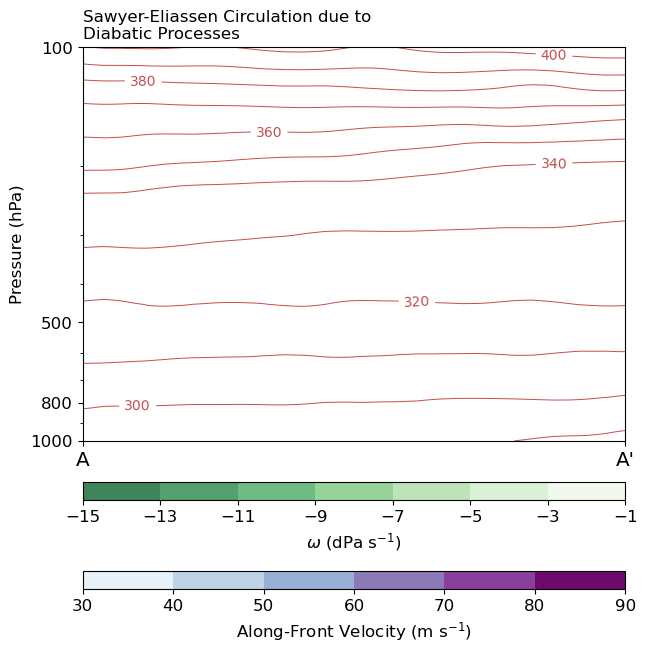

In [47]:
# Make a plot to visualize the circulation

plt.figure(figsize=(7,8))

# Set contouring intervals for along-front velocity, potential temperature, vertical velocity
# in the Sawyer-Eliassen circulation, and the Sawyer-Eliassen streamfunction.
# Avoid contouring 0 for the streamfunction.
clev_uprime = np.arange(30,100,10)
clev_tpot   = np.arange(200,500,10)
clev_wSE    = np.arange(-15.0,1.0,2.0)
clev_psi    = np.append(np.arange(-3000,0,500),np.arange(500,3000,500))

# Add shading for the along-front velocity    
contf_uprime = plt.contourf(uprime.index, 
                            uprime.level, 
                            uprime, 
                            levels = clev_uprime, 
                            cmap = cm['BuPu'])
cbar_uprime = plt.colorbar(contf_uprime, orientation='horizontal', aspect=30, pad=0.02)
cbar_uprime.set_label(r'Along-Front Velocity (m s$^{-1}$)', fontsize='large')
cbar_uprime.ax.tick_params(labelsize='large')

# Add thin contour lines to help make shading of along-front velocity more visible
cont_uprime = plt.contour(xsect.index, 
                          xsect.level, 
                          uprime, 
                          levels = clev_uprime, 
                          linestyles='solid', 
                          linewidths=0.3, colors='k')

# Add contours pf potential temperature
cont_tpot = plt.contour(xsect['tpot'].index, 
                        xsect['tpot'].level, 
                        xsect['tpot'], 
                        levels = clev_tpot, 
                        linestyles='solid', 
                        linewidths=0.7, 
                        colors='firebrick', alpha=0.8)
plt.clabel(cont_tpot, levels=clev_tpot[::2], manual=False)

# Add shading of ascent generated by the circulation
# Multiply by 10 to convert to dPa/s
contf_wSE = plt.contourf(xsect.index, 
                        xsect.level, 
                        wSE*10, 
                        levels = clev_wSE, 
                        cmap = cm['Greens_r'], 
                        alpha=0.75)
cbar_wSE = plt.colorbar(contf_wSE, orientation='horizontal',aspect=30, pad=0.08)
cbar_wSE.set_label(r'$\omega$ (dPa s$^{-1}$)', fontsize='large')
cbar_wSE.ax.tick_params(labelsize='large')

# Add thin contour lines to help make shading of ascent more visible
cont_wSE = plt.contour(xsect.index, 
                       xsect.level,
                       wSE*10,
                       levels = clev_wSE, 
                       linestyles='solid', 
                       linewidths=0.3, 
                       colors='darkgreen', alpha=0.75)


# Add contours for the Sawyer-Eliassen streamfunction
# Convert psi to m(hPa)/s
psi_contour = plt.contour(psi_da.index, 
                          psi_da.level, 
                          psi_da/100, 
                          levels = clev_psi,
                          colors = 'black', 
                          linewidths=1.5)
plt.clabel(psi_contour, levels = clev_psi[1::2])

# Adjust y-axis to have inverted, log-scale pressure values
ax = plt.gca()
ax.invert_yaxis()
plt.yscale('log')
plt.ylabel('Pressure (hPa)',fontsize='large')
ax.tick_params(axis='y',labelsize='large')

# Manually set y-axis ticks
ax.set_yticks([1000, 800, 500, 100])
ax.set_yticklabels(['1000', '800', '500', '100'])
ax.yaxis.set_minor_formatter(NullFormatter())

# Label x axis with start (A) and end (A') of cross section
ax.set_xticks([0,int(max(xsect.index))])
ax.set_xticklabels(['A','A\''])
ax.tick_params(axis='x',labelsize='x-large')
    
# Add title according to forcing
forcing_titles = {'full'     : 'Geostrophic and Diabatic Processes',
                  'Q_g'      : 'Geostrophic Processes',
                  'Q_gST'    : 'Geostrophic Confluence',
                  'Q_gSH'    : 'Geostrophic Shearing',
                  'diabatic' : 'Diabatic Processes'}
ax.set_title('Sawyer-Eliassen Circulation due to\n'+forcing_titles[forcing], fontsize='large', loc='left')
#ax.set_title('Valid: '+time, loc='right')

# Save plot
#plt.savefig('SEcirc_'+forcing+'.pdf',facecolor='white')
plt.ylim(1000,100)
plt.show()

In [36]:
start_point = (30, 360 - 134) # units: degrees North, degrees East
end_point = (36, 360 - 127) # units: degrees North, degrees East

In [37]:
wind_speed_250

Magnitude,[[52.311954498291016 52.22530746459961 52.13279342651367 ... 9.612676620483398 9.663491249084473 9.695586204528809] [51.56051254272461 51.31901550292969 51.15983581542969 ... 10.691888809204102 10.751102447509766 10.787577629089355] [50.76002502441406 50.44919967651367 50.228084564208984 ... 11.662040710449219 11.715424537658691 11.749737739562988] ... [66.06413269042969 66.49581909179688 66.88651275634766 ... 28.402070999145508 27.96915626525879 28.122234344482422] [65.84369659423828 66.2052993774414 66.54328155517578 ... 27.890789031982422 27.21599006652832 27.098649978637695] [65.18053436279297 65.52642059326172 65.85431671142578 ... 27.543216705322266 26.735322952270508 26.346006393432617]]
Units,meter/second


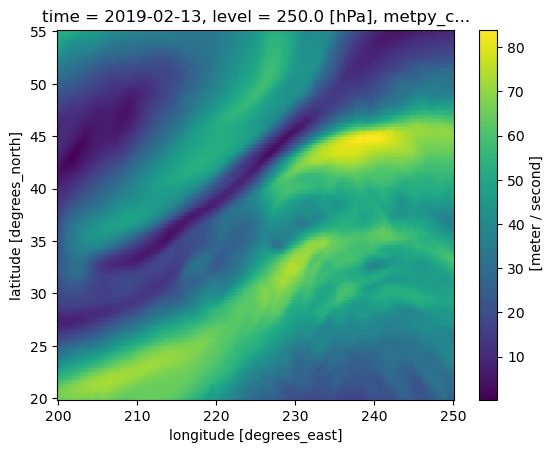

In [38]:
wind_speed_250.plot()

In [39]:
wind_speed_250

Magnitude,[[52.311954498291016 52.22530746459961 52.13279342651367 ... 9.612676620483398 9.663491249084473 9.695586204528809] [51.56051254272461 51.31901550292969 51.15983581542969 ... 10.691888809204102 10.751102447509766 10.787577629089355] [50.76002502441406 50.44919967651367 50.228084564208984 ... 11.662040710449219 11.715424537658691 11.749737739562988] ... [66.06413269042969 66.49581909179688 66.88651275634766 ... 28.402070999145508 27.96915626525879 28.122234344482422] [65.84369659423828 66.2052993774414 66.54328155517578 ... 27.890789031982422 27.21599006652832 27.098649978637695] [65.18053436279297 65.52642059326172 65.85431671142578 ... 27.543216705322266 26.735322952270508 26.346006393432617]]
Units,meter/second


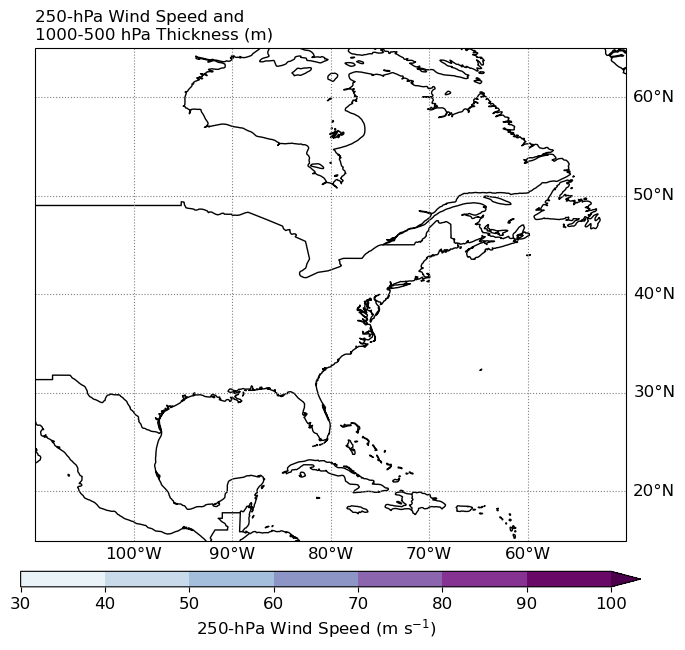

In [40]:
# Make the plot

# Set up projections used for the map and the data
mapcrs  = ccrs.PlateCarree(central_longitude= lonW + ((lonE-lonW)/2))
datacrs = ccrs.PlateCarree()

# Set contouring intervals
clev_spd   = np.arange(30,110,10)      # in meters/second
clev_thick = np.arange(4000,7000,100)   # in meters

# Set figure size
fig_map = plt.figure(figsize=(8,8))

# Create axes and set extent
ax_map = plt.axes(projection = mapcrs)
ax_map.set_extent([-110, -50, 15, 65], datacrs)

# Add geopolitical boundaries
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.BORDERS)

#Add gridlines and remove top + left labels
gridlines = ax_map.gridlines(color='gray',ls='dotted',draw_labels=True)
gridlines.top_labels  = False
gridlines.left_labels = False
gridlines.xlabel_style = {'size': 'large'}
gridlines.ylabel_style = {'size': 'large'}

# Add shading of wind speed
contf = ax_map.contourf(wind_speed_250.longitude, wind_speed_250.latitude, 
                        wind_speed_250, 
                        clev_spd,
                        cmap=plt.cm.BuPu,
                        extend='max',
                        transform=datacrs)

# Add colorbar for omega shading
cbar = plt.colorbar(contf, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label(r'250-hPa Wind Speed (m s$^{-1}$)', size='large')
cbar.ax.tick_params(labelsize='large')
                  
# Add contours of thickness                 
#cont = ax_map.contour(thick.longitude, thick.latitude, 
#                      thick, 
#                      clev_thick, 
#                      colors='firebrick',
#                      linewidths=2.0, transform=datacrs)
#plt.clabel(cont, fontsize=10, inline=1, inline_spacing=3, rightside_up=True, use_clabeltext=True)  
                               
# Plot cross section using provided start and end coordinates
# Cross section will start at A and run to A'
#plt.plot([start_lon, end_lon], [start_lat, end_lat], c='k', linewidth = 2.0, transform=datacrs)
#plt.scatter([start_lon, end_lon], [start_lat, end_lat], c='k', s=35, transform=datacrs)
#plt.text(start_lon - 2, start_lat - 2, 'A', c='k', fontsize=14, fontweight='bold', transform=datacrs) # warm side of front
#plt.text(end_lon + 2, end_lat - 2, 'A\'' , c='k', fontsize=14, fontweight='bold', transform=datacrs)  # cold side of front
                  
# Add title
plt.title('250-hPa Wind Speed and\n1000-500 hPa Thickness (m)',loc='left')
#plt.title('Valid: '+time, loc='right')

# Save figure and show
#plt.savefig('wind_thick_xsec.pdf')
plt.show()

In [41]:
# Load in variables we need and add units
u_3d = file['u'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
u_3d = u_3d * units.meter / units.second
v_3d = file['v'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
v_3d = v_3d * units.meter / units.second
gp_3d = file['z'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
gp_3d = gp_3d * (units.meter**2) / (units.second**2)

# Convert geopotential to geopotential height by dividing by gravity
gph_3d = gp_3d / (9.81 * units.meter / (units.second**2))
del gp_3d

# Calculate 250-hPa wind speed
spd_250 = ((u_3d.sel(pressure_level=250)**2) + (v_3d.sel(pressure_level=250)**2))**(1/2)

# Calculate 1000-500 hPa thickness
thick = gph_3d.sel(pressure_level=500) - gph_3d.sel(pressure_level=1000)

# Apply Gaussian smoothing in the latitude and longitude dimensions
# "degree" is an integer that adjusts the smoothing (a larger degree means more dramatic smoothing)
#degree = 25
#temp_3d = mpcalc.smooth_gaussian(temp_3d_era5, n=degree)
#gph_3d  = mpcalc.smooth_gaussian(gph_3d_era5, n=degree)

NameError: name 'file' is not defined